# Predicting house price with Gaussian process regression

A competition project from Kaggle (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/)

Let's get started!

Uncomment and run the cell below to install the Libararies we are going to use in this notebook. Skip if you have them already.

In [1]:
#!pip3 install -U scikit-learn

In [13]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from sklearn import preprocessing, model_selection, gaussian_process

%matplotlib inline

Load the training dataset and see what are the features does it have

In [33]:
train = pd.read_csv('train.csv')

Remove the first column (house Ids). Let see what percentage of data are missing in each column and drop the ones that have too many missing values

In [34]:
train.drop('Id', axis=1, inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [35]:
cols = ['Alley','FireplaceQu','PoolQC','Fence','MiscFeature']
train = train.drop(cols, axis=1)
print('train set size after removing nan columns: ', train.shape)

train set size after removing nan columns:  (1460, 75)


Let's see how some of features are correlated with the sale price

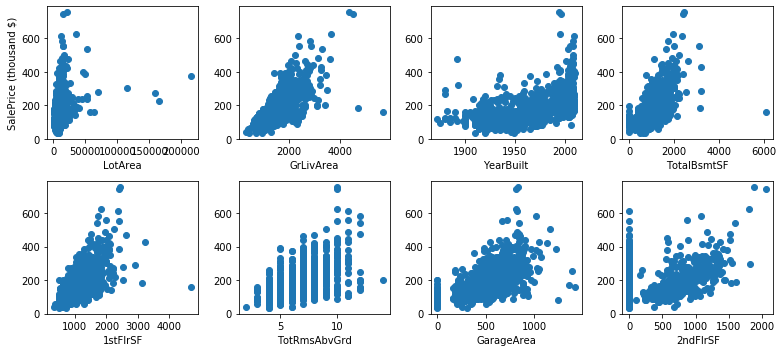

In [36]:
fig = plt.figure(figsize=(11, 5))

ax = fig.add_subplot(2,4,1)
ax.scatter(train.LotArea, train.SalePrice/1e3)
ax.set_xlabel('LotArea')
ax.set_ylabel('SalePrice (thousand $)')

ax = fig.add_subplot(2,4,2)
ax.scatter(train.GrLivArea, train.SalePrice/1e3)
ax.set_xlabel('GrLivArea')

ax = fig.add_subplot(2,4,3)
ax.scatter(train.YearBuilt, train.SalePrice/1e3)
ax.set_xlabel('YearBuilt')

ax = fig.add_subplot(2,4,4)
ax.scatter(train.TotalBsmtSF, train.SalePrice/1e3)
ax.set_xlabel('TotalBsmtSF')

ax = fig.add_subplot(2,4,5)
ax.scatter(train['1stFlrSF'], train.SalePrice/1e3)
ax.set_xlabel('1stFlrSF')

ax = fig.add_subplot(2,4,6)
ax.scatter(train.TotRmsAbvGrd, train.SalePrice/1e3)
ax.set_xlabel('TotRmsAbvGrd')

ax = fig.add_subplot(2,4,7)
ax.scatter(train.GarageArea, train.SalePrice/1e3)
ax.set_xlabel('GarageArea')

ax = fig.add_subplot(2,4,8)
ax.scatter(train['2ndFlrSF'], train.SalePrice/1e3)
ax.set_xlabel('2ndFlrSF')

fig.tight_layout();

In [38]:
train = train.drop(train[(train['LotArea']>60000) & (train['SalePrice']<400000)].index)
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
train = train.drop(train[(train['TotalBsmtSF']>4000)].index)
train = train.drop(train[(train['1stFlrSF']>4000)].index)

Some features are numeric and the others are categorical. Let identify the type of each feature and replace missing values in the numeric columns with its average. We can also replace missing categorical values with a random caegory. Obviously, this is something to tune to obtain the most optimal performance.

In [39]:
train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].mean())
train['MasVnrArea'] = train['MasVnrArea'].fillna(train['MasVnrArea'].mean())
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(train['GarageYrBlt'].mean())

In [40]:
train['MasVnrType'] = train['MasVnrType'].fillna('None');
train['BsmtQual'] = train['BsmtQual'].fillna('TA');
train['BsmtCond'] = train['BsmtCond'].fillna('TA');
train['BsmtExposure'] = train['BsmtExposure'].fillna('No')
train['BsmtFinType1'] = train['BsmtFinType1'].fillna('Unf')
train['BsmtFinType2'] = train['BsmtFinType2'].fillna('Unf')
train['Electrical'] = train['Electrical'].fillna('SBrkr')
train['GarageType'] = train['GarageType'].fillna('Attchd')
train['GarageFinish'] = train['GarageFinish'].fillna('RFn')
train['GarageQual']= train['GarageQual'].fillna('TA')
train['GarageCond'] = train['GarageCond'].fillna('TA')

In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1453 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1453 non-null   int64  
 1   MSZoning       1453 non-null   object 
 2   LotFrontage    1453 non-null   float64
 3   LotArea        1453 non-null   int64  
 4   Street         1453 non-null   object 
 5   LotShape       1453 non-null   object 
 6   LandContour    1453 non-null   object 
 7   Utilities      1453 non-null   object 
 8   LotConfig      1453 non-null   object 
 9   LandSlope      1453 non-null   object 
 10  Neighborhood   1453 non-null   object 
 11  Condition1     1453 non-null   object 
 12  Condition2     1453 non-null   object 
 13  BldgType       1453 non-null   object 
 14  HouseStyle     1453 non-null   object 
 15  OverallQual    1453 non-null   int64  
 16  OverallCond    1453 non-null   int64  
 17  YearBuilt      1453 non-null   int64  
 18  YearRemo

Now we are going to replace categorical features with numeric values. 'LabelEncoder' can be used to normalize labels.

In [42]:
le = preprocessing.LabelEncoder()
for col in train.columns :
    if train[col].dtype == object : 
        le.fit(train[col])
        train[col] = le.transform(train[col])
 

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1453 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1453 non-null   int64  
 1   MSZoning       1453 non-null   int64  
 2   LotFrontage    1453 non-null   float64
 3   LotArea        1453 non-null   int64  
 4   Street         1453 non-null   int64  
 5   LotShape       1453 non-null   int64  
 6   LandContour    1453 non-null   int64  
 7   Utilities      1453 non-null   int64  
 8   LotConfig      1453 non-null   int64  
 9   LandSlope      1453 non-null   int64  
 10  Neighborhood   1453 non-null   int64  
 11  Condition1     1453 non-null   int64  
 12  Condition2     1453 non-null   int64  
 13  BldgType       1453 non-null   int64  
 14  HouseStyle     1453 non-null   int64  
 15  OverallQual    1453 non-null   int64  
 16  OverallCond    1453 non-null   int64  
 17  YearBuilt      1453 non-null   int64  
 18  YearRemo

Now we are going to z-score features and the sale prices

In [43]:
SalePrice = train.SalePrice
train = train.drop('SalePrice', axis=1)

for col in train.columns :
    train[col] = (train[col] - train[col].mean())/train[col].std()

In [44]:
SalePrice = np.array(SalePrice).reshape(SalePrice.shape[0], 1)
mu = SalePrice.mean()
sigma = SalePrice.std()
SalePrice = (SalePrice - mu)/sigma

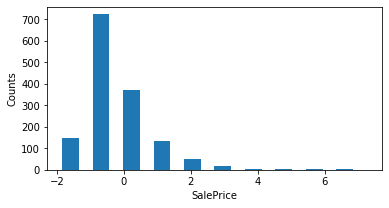

In [46]:
fig = plt.figure(figsize=(6,3))

plt.hist(SalePrice, width=0.5)
plt.xlabel('SalePrice')
plt.ylabel('Counts');

Save 20% of training set as cross-validation set to use it for tuning hyperparameters of the networks e.g. learning rate, number of epochs, number of hidden layers, ...

In [47]:
train = train.to_numpy()
train_x, xvalid_x, train_y, xvalid_y = model_selection.train_test_split(train, SalePrice, train_size=0.8, shuffle=True)
print(train_x.shape, train_y.shape, xvalid_x.shape, xvalid_y.shape)
print(type(train_x), type(train_y))

(1162, 74) (1162, 1) (291, 74) (291, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


# STEPS TO PERFORM GPR
### 1. Create the kernel

In [48]:
kernel = gaussian_process.kernels.DotProduct() + gaussian_process.kernels.WhiteKernel()

### 2. Perform the regression

In [49]:
regressor = gaussian_process.GaussianProcessRegressor(kernel=kernel)

### 3. Fit the data


In [50]:
gpr = regressor.fit(train_x, train_y)

### 4. Examine the performance on cross-validation set


In [51]:
xvalid_pred = gpr.predict(xvalid_x)

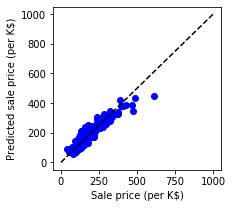

In [52]:
fig = plt.figure(figsize=(3,3))

plt.plot((xvalid_y[:,0]*sigma+mu)/1e3, (xvalid_pred[:,0]*sigma+mu)/1e3, 'bo')
plt.plot([0,1e3], [0,1e3], 'k--')
plt.xlabel('Sale price (per K$)')
plt.ylabel('Predicted sale price (per K$)');

Now we are going to clean and preprocess the test dataset just like what we did for the training dataset

In [53]:
test = pd.read_csv('test.csv')

test_ids = test.Id
test.drop('Id', axis=1, inplace=True)
print('test set size: ', test.shape)
test.info()

test set size:  (1459, 79)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1455 non-null   object 
 2   LotFrontage    1232 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          107 non-null    object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1457 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-n

In [54]:
cols = ['Alley','FireplaceQu','PoolQC','Fence','MiscFeature']
test = test.drop(cols, axis=1)
print('test set size after removing nan columns: ', test.shape)

test set size after removing nan columns:  (1459, 74)


In [55]:
test['LotFrontage'] = test['LotFrontage'].fillna(test['LotFrontage'].mean())
test['MasVnrArea'] = test['MasVnrArea'].fillna(test['MasVnrArea'].mean())
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(test['GarageYrBlt'].mean())

test['MasVnrType'] = test['MasVnrType'].fillna('None');
test['BsmtQual'] = test['BsmtQual'].fillna('TA');
test['BsmtCond'] = test['BsmtCond'].fillna('TA');
test['BsmtExposure'] = test['BsmtExposure'].fillna('Mn')
test['BsmtFinType1'] = test['BsmtFinType1'].fillna('ALQ')
test['BsmtFinType2'] = test['BsmtFinType2'].fillna('Unf')
test['Electrical'] = test['Electrical'].fillna('SBrkr')
test['GarageType'] = test['GarageType'].fillna('Attchd')
test['GarageFinish'] = test['GarageFinish'].fillna('RFn')
test['GarageQual']= test['GarageQual'].fillna('TA')
test['GarageCond'] = test['GarageCond'].fillna('TA')

In [57]:
test['BsmtFinSF1'] = test['BsmtFinSF1'].fillna(test['BsmtFinSF1'].mean())
test['BsmtFinSF2'] = test['BsmtFinSF2'].fillna(test['BsmtFinSF2'].mean())
test['BsmtUnfSF'] = test['BsmtUnfSF'].fillna(test['BsmtUnfSF'].mean())
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(test['TotalBsmtSF'].mean())
test['BsmtFullBath'] = test['BsmtFullBath'].fillna(test['BsmtFullBath'].mean())
test['BsmtHalfBath'] = test['BsmtHalfBath'].fillna(test['BsmtHalfBath'].mean())
test['GarageCars'] = test['GarageCars'].fillna(test['GarageCars'].mean())
test['GarageArea'] = test['GarageArea'].fillna(test['GarageArea'].mean())

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1455 non-null   object 
 2   LotFrontage    1459 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   LotShape       1459 non-null   object 
 6   LandContour    1459 non-null   object 
 7   Utilities      1457 non-null   object 
 8   LotConfig      1459 non-null   object 
 9   LandSlope      1459 non-null   object 
 10  Neighborhood   1459 non-null   object 
 11  Condition1     1459 non-null   object 
 12  Condition2     1459 non-null   object 
 13  BldgType       1459 non-null   object 
 14  HouseStyle     1459 non-null   object 
 15  OverallQual    1459 non-null   int64  
 16  OverallCond    1459 non-null   int64  
 17  YearBuilt      1459 non-null   int64  
 18  YearRemo

In [58]:
le = preprocessing.LabelEncoder()
for col in test.columns :
    if test[col].dtype == object :
        test[col] = test[col].astype(str) 
        le.fit(test[col])
        test[col] = le.transform(test[col])
        
for col in test.columns :
    test[col] = (test[col] - test[col].mean())/test[col].std()

In [60]:
test_pred = gpr.predict(test)

test_price_pred = test_pred*sigma + mu
test_price_pred = test_price_pred.reshape(test_pred.shape[0], 1)
print(test_price_pred)

[[119064.92021565]
 [159836.51164001]
 [184500.9602791 ]
 ...
 [167190.70123793]
 [126035.70032253]
 [233386.05316285]]


Submission file contains house IDs that are in the test set. Save the predicted prices to submit to kaggle.

In [61]:
submission = pd.read_csv('sample_submission.csv')
submission.SalePrice = test_price_pred
submission
submission.to_csv ('submission.csv', index = None, header = True)